<a href="https://colab.research.google.com/github/hadinursalim/Bioinformatics/blob/main/ECG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Data Klasifikasi Detak Jantung EKG**

Pembuatan model pembelajaran mesin untuk mengklasifikasikan data yang diberikan diperoleh sebagai EKG detak jantung ke dalam kelas yang berbeda. Seperti yang diberikan dalam dataset, terdapat 5 kelas detak jantung yang berbeda sebagai [N:0, S:1, V:2 , F:3, Q:4]

* N: Ketukan Non-Ektopik
* S: Ketukan Ektopik Superventrial
* V: Denyut Ektopik Ventrikel
* F: Fusion Beats
* T: Ketukan Tidak Diketahui

**Algoritma CNN** yang akan kita terapkan akan mengklasifikasikan detak jantung yang diberikan ke dalam salah satu kelas ini

In [ ]:
# importing libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, tqdm, re, time, itertools, sys
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix
from keras.layers import Conv2D, Conv1D, MaxPooling2D, MaxPooling1D, Flatten, BatchNormalization, Dense
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.callbacks import CSVLogger, ModelCheckpoint
import matplotlib.pyplot as plt

In [ ]:
import warnings
warnings.filterwarnings('ignore')

**Memuat Data**
Langkah pertama adalah memuat data dalam memori kita.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Path dari masing_masing data di google drive

mit_test = "/content/drive/MyDrive/EKG/mitbih_test.csv" 
mit_train = "/content/drive/MyDrive/EKG/mitbih_train.csv"
ptb_abnormal = "/content/drive/MyDrive/EKG/ptbdb_abnormal.csv"
ptb_normal = "/content/drive/MyDrive/EKG/ptbdb_normal.csv"

In [ ]:
# loading all data files into memory
start = time.time()

mit_train = pd.read_csv("/content/drive/MyDrive/EKG/mitbih_train.csv", header=None)
mit_test= pd.read_csv("/content/drive/MyDrive/EKG/mitbih_test.csv", header=None)
ptb_abnormal = pd.read_csv("/content/drive/MyDrive/EKG/ptbdb_abnormal.csv", header=None)
ptb_normal = pd.read_csv("/content/drive/MyDrive/EKG/ptbdb_normal.csv", header=None)

end = time.time()
print('Time taken: %.3f seconds' % (end-start))

print('Data loaded........')

Time taken: 9.272 seconds
Data loaded........


In [ ]:
mit_test.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.758264,0.111570,0.000000,0.080579,0.078512,0.066116,0.049587,0.047521,0.035124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.908425,0.783883,0.531136,0.362637,0.366300,0.344322,0.333333,0.307692,0.296703,0.300366,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.730088,0.212389,0.000000,0.119469,0.101770,0.101770,0.110619,0.123894,0.115044,0.132743,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.910417,0.681250,0.472917,0.229167,0.068750,0.000000,0.004167,0.014583,0.054167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.570470,0.399329,0.238255,0.147651,0.000000,0.003356,0.040268,0.080537,0.070470,0.090604,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
mit_train.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
ptb_abnormal.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.932233,0.869679,0.886186,0.929626,0.908775,0.933970,0.801043,0.749783,0.687229,0.635100,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.000000,0.606941,0.384181,0.254237,0.223567,0.276836,0.253430,0.184826,0.153349,0.121872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.000000,0.951613,0.923963,0.853303,0.791859,0.734255,0.672043,0.685100,0.670507,0.667435,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.977819,0.899261,0.230129,0.032348,0.142329,0.223660,0.328096,0.367837,0.381701,0.389094,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.935618,0.801661,0.805815,1.000000,0.722741,0.480789,0.454829,0.319834,0.266874,0.308411,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
mit_test.rename(columns={187:"Class"}, inplace=True)
mit_train.rename(columns={187:"Class"}, inplace=True)
ptb_abnormal.rename(columns={187:"Class"}, inplace=True)
ptb_normal.rename(columns={187:"Class"}, inplace=True)

In [ ]:
print ("MIT Train classes: \n", mit_train["Class"].value_counts())
print ("\nMIT Test classes: \n", mit_test["Class"].value_counts())
print ("\nPTB Abnormal classes: \n", ptb_abnormal["Class"].value_counts())
print ("\nPTB Normal classes: \n", ptb_normal["Class"].value_counts())

MIT Train classes: 
 0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: Class, dtype: int64

MIT Test classes: 
 0.0    18118
4.0     1608
2.0     1448
1.0      556
3.0      162
Name: Class, dtype: int64

PTB Abnormal classes: 
 1.0    10506
Name: Class, dtype: int64

PTB Normal classes: 
 0.0    4046
Name: Class, dtype: int64


In [ ]:
# Setting Dictionary to define the type of Heartbeat for both datasets
MIT_Outcome = {0. : 'Normal Beat',
               1. : 'Supraventricular premature beat',
               2. : 'Premature ventricular contraction',
               3. : 'Fusion of ventricular and normal beat',
               4. : 'Unclassifiable beat'}
PTB_Outcome = {0. : 'Normal',
               1. : 'Abnormal'}

**Generating Plots of some of the samples in the dataset**

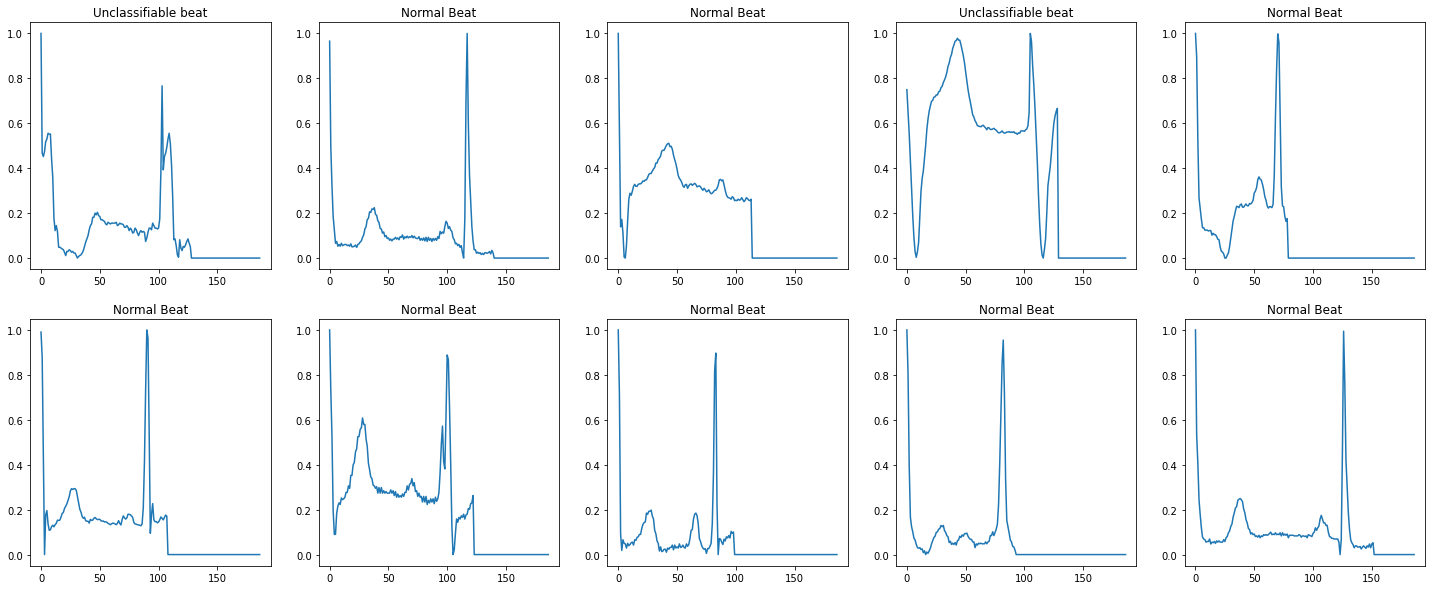

In [ ]:
#Plotting 10 random samples from the MIT training dataset with their classification
plt.figure(figsize=(25,10))
np_count = np.linspace(0,186,187)
np_time = np.tile(np_count,(10,1))
rnd = np.random.randint(0,mit_train.shape[0],size=(10,))


for i in range(np_time.shape[0]):
    ax = plt.subplot(2,5,i+1)
    ax.plot(mit_train.iloc[rnd[i],np_time[i,:]])
    ax.set_title(MIT_Outcome[mit_train.loc[rnd[i],'Class']])

plt.show()

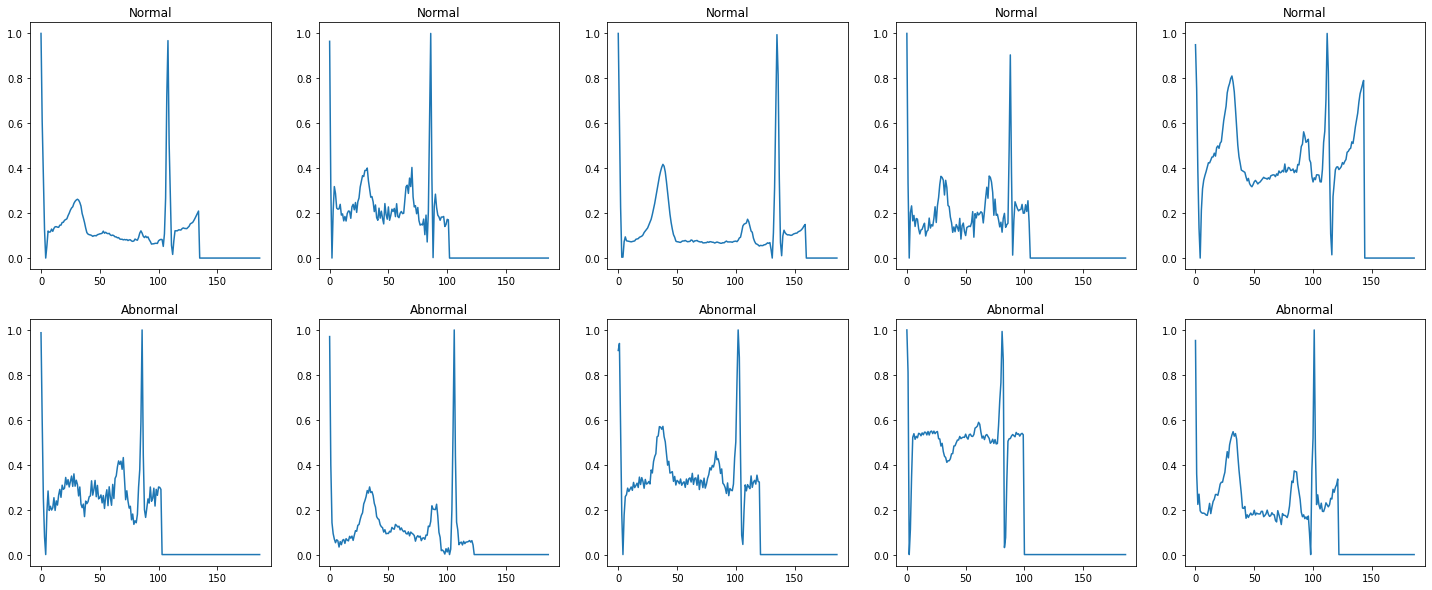

In [ ]:
#Plotting 10 random samples from the PTB training dataset with their classification
plt.figure(figsize=(25,10))
rnd = np.random.randint(0,ptb_normal.shape[0],size=(5,))
rnd1 = np.random.randint(0,ptb_abnormal.shape[0], size=(5,))

for i in range(np_time.shape[0]):
    ax = plt.subplot(2,5,i+1)
    if (i < 5):
        ax.plot(ptb_normal.iloc[rnd[i],np_time[i,:]])
        ax.set_title(PTB_Outcome[ptb_normal.loc[rnd[i],'Class']])
    else:
        ax.plot(ptb_abnormal.iloc[rnd1[i-5],np_time[i,:]])
        ax.set_title(PTB_Outcome[ptb_abnormal.loc[rnd1[i-5],'Class']])

plt.show()

**Deep Learning Analysis**

In [ ]:
!pip install --user tensorflow-addons==0.8.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 6.9 MB/s 
  Attempting uninstall: tensorflow-addons
    Found existing installation: tensorflow-addons 0.8.3
    Uninstalling tensorflow-addons-0.8.3:
      Successfully uninstalled tensorflow-addons-0.8.3


In [ ]:
import tensorflow_addons as tfa

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Flatten, Dropout, InputLayer, LSTM, GRU, BatchNormalization, Bidirectional, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.utils import to_categorical

In [ ]:
#Preparing the training, validation and test sets for the PTB Data set
ptb_full = pd.concat([ptb_normal, ptb_abnormal], axis=0).reset_index()
ptb_full.drop(columns='index', inplace=True)
ptb_full = ptb_full.sample(ptb_full.shape[0], random_state=42)
train_ptb, test_ptb, out_train_ptb, out_test_ptb = train_test_split(ptb_full.iloc[:,:187], ptb_full.iloc[:,-1], test_size=0.15, random_state=42)
train_ptb, valid_ptb, out_train_ptb, out_valid_ptb = train_test_split(train_ptb, out_train_ptb, test_size=0.2, random_state=42 )

**Calculating the class weight**
Create a dictionary of each class weight to feed into the model since the data is imbalanced

In [ ]:
normal, abnormal = np.bincount(ptb_full.loc[:,'Class'])
norm_weight = (1/normal) * ((normal+abnormal)/2)
abnorm_weight = (1/abnormal) * ((normal+abnormal)/2)
class_weight = {0: norm_weight, 1: abnorm_weight}

In [ ]:
print("Traing dataset size: ", train_ptb.shape)
print("Validation dataset size: ", valid_ptb.shape)
print("Test dataset size: ", test_ptb.shape)

Traing dataset size:  (9895, 187)
Validation dataset size:  (2474, 187)
Test dataset size:  (2183, 187)


In [ ]:
#Normalizing the training, validation & test data 
train_ptb = normalize(train_ptb, axis=0, norm='max')
valid_ptb = normalize(valid_ptb, axis=0, norm='max')
test_ptb = normalize(test_ptb, axis=0, norm='max')

In [ ]:
# Reshaping the dataframe into a 3-D Numpy array (batch, Time Period, Value)
x_train_ptb = train_ptb.reshape(len(train_ptb),train_ptb.shape[1],1)
x_valid_ptb = valid_ptb.reshape(len(valid_ptb),valid_ptb.shape[1],1)
x_test_ptb = test_ptb.reshape(len(test_ptb),test_ptb.shape[1],1)

# Converting the output into a categorical array
y_train_ptb = to_categorical(out_train_ptb)
y_valid_ptb = to_categorical(out_valid_ptb)
y_test_ptb = to_categorical(out_test_ptb)

In [ ]:
print("Traing dataset size: ", x_train_ptb.shape , " -- Y size: ", y_train_ptb.shape)
print("Validation dataset size: ", x_valid_ptb.shape , " -- Y size: ", y_valid_ptb.shape)
print("Test dataset size: ", x_test_ptb.shape , " -- Y size: ", y_test_ptb.shape)

Traing dataset size:  (9895, 187, 1)  -- Y size:  (9895, 2)
Validation dataset size:  (2474, 187, 1)  -- Y size:  (2474, 2)
Test dataset size:  (2183, 187, 1)  -- Y size:  (2183, 2)


In [ ]:
tf.keras.backend.clear_session()

#Function to build Convolutional 1D Networks
def build_conv1d_model (input_shape=(x_train_ptb.shape[1],1)):
    model = keras.models.Sequential()
    
    model.add(Conv1D(32,7, padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    model.add(MaxPool1D(5,padding='same'))

    model.add(Conv1D(64,7, padding='same'))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    model.add(MaxPool1D(5,padding='same'))

    model.add(Conv1D(128,7, padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    model.add(MaxPool1D(5,padding='same'))
    model.add(Conv1D(256,7, padding='same'))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    model.add(MaxPool1D(5,padding='same'))
    model.add(Conv1D(512,7, padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    model.add(MaxPool1D(5,padding='same'))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(2, activation="softmax"))
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=[tfa.metrics.F1Score(2,"micro")])
    return model

In [ ]:
checkpoint_cb = ModelCheckpoint("conv1d_ptb.h5", save_best_only=True)

earlystop_cb = EarlyStopping(patience=5, restore_best_weights=True)

model_conv1d_ptb= build_conv1d_model(input_shape=(x_train_ptb.shape[1], x_train_ptb.shape[2]))
model_conv1d_ptb.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 187, 32)           256       
                                                                 
 batch_normalization (BatchN  (None, 187, 32)          128       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 187, 32)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 38, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 38, 64)            14400     
                                                                 
 batch_normalization_1 (Batc  (None, 38, 64)           2

In [ ]:
history_conv1d_ptb = model_conv1d_ptb.fit(x_train_ptb, y_train_ptb, epochs=40, batch_size=32, 
                                          class_weight=class_weight, validation_data=(x_valid_ptb, y_valid_ptb),  
                                          callbacks=[checkpoint_cb, earlystop_cb])

Epoch 1/40
310/310 [==============================] - 3s 11ms/step - loss: 0.0814 - f1_score: 0.9717 - val_loss: 0.8694 - val_f1_score: 0.7769
Epoch 2/40
310/310 [==============================] - 3s 10ms/step - loss: 0.0648 - f1_score: 0.9768 - val_loss: 0.0567 - val_f1_score: 0.9782
Epoch 3/40
310/310 [==============================] - 3s 10ms/step - loss: 0.0512 - f1_score: 0.9826 - val_loss: 0.3781 - val_f1_score: 0.9078
Epoch 4/40
310/310 [==============================] - 3s 10ms/step - loss: 0.0513 - f1_score: 0.9812 - val_loss: 0.0984 - val_f1_score: 0.9628
Epoch 5/40
310/310 [==============================] - 3s 11ms/step - loss: 0.0455 - f1_score: 0.9852 - val_loss: 0.5651 - val_f1_score: 0.9103
Epoch 6/40
310/310 [==============================] - 3s 11ms/step - loss: 0.0462 - f1_score: 0.9822 - val_loss: 0.0892 - val_f1_score: 0.9580
Epoch 7/40
310/310 [==============================] - 3s 10ms/step - loss: 0.0442 - f1_score: 0.9854 - val_loss: 0.0538 - val_f1_score: 0.9810

In [ ]:
model_conv1d_ptb.load_weights("conv1d_ptb.h5")
model_conv1d_ptb.evaluate(x_test_ptb,y_test_ptb)

69/69 [==============================] - 0s 4ms/step - loss: 0.0365 - f1_score: 0.9908


[0.036474425345659256, 0.9908382892608643]

In [ ]:
# Calculating the predictions based on the highest probability class
conv1d_pred_proba_ptb = model_conv1d_ptb.predict (x_test_ptb)
conv1d_pred_ptb = np.argmax(conv1d_pred_proba_ptb, axis=1)

In [ ]:
print(classification_report(out_test_ptb, conv1d_pred_ptb > 0.5, target_names=[PTB_Outcome[i] for i in PTB_Outcome]))

              precision    recall  f1-score   support

      Normal       0.99      0.98      0.98       616
    Abnormal       0.99      1.00      0.99      1567

    accuracy                           0.99      2183
   macro avg       0.99      0.99      0.99      2183
weighted avg       0.99      0.99      0.99      2183



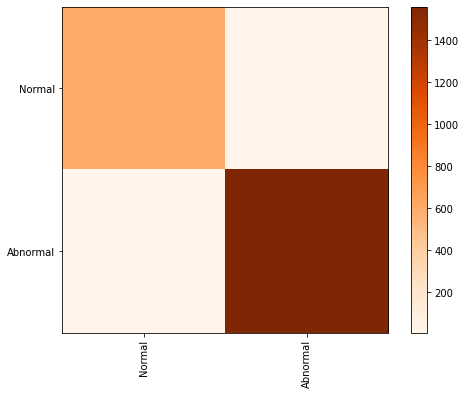

In [ ]:
cm = confusion_matrix(y_true= out_test_ptb, y_pred=conv1d_pred_ptb, labels=list(PTB_Outcome.keys()))
plt.figure(figsize=(8,6))
plt.imshow(cm, cmap="Oranges")
plt.colorbar()
plt.xticks(list(PTB_Outcome.keys()),[PTB_Outcome[i] for i in PTB_Outcome], rotation=90)
plt.yticks(list(PTB_Outcome.keys()),[PTB_Outcome[i] for i in PTB_Outcome])
plt.show()

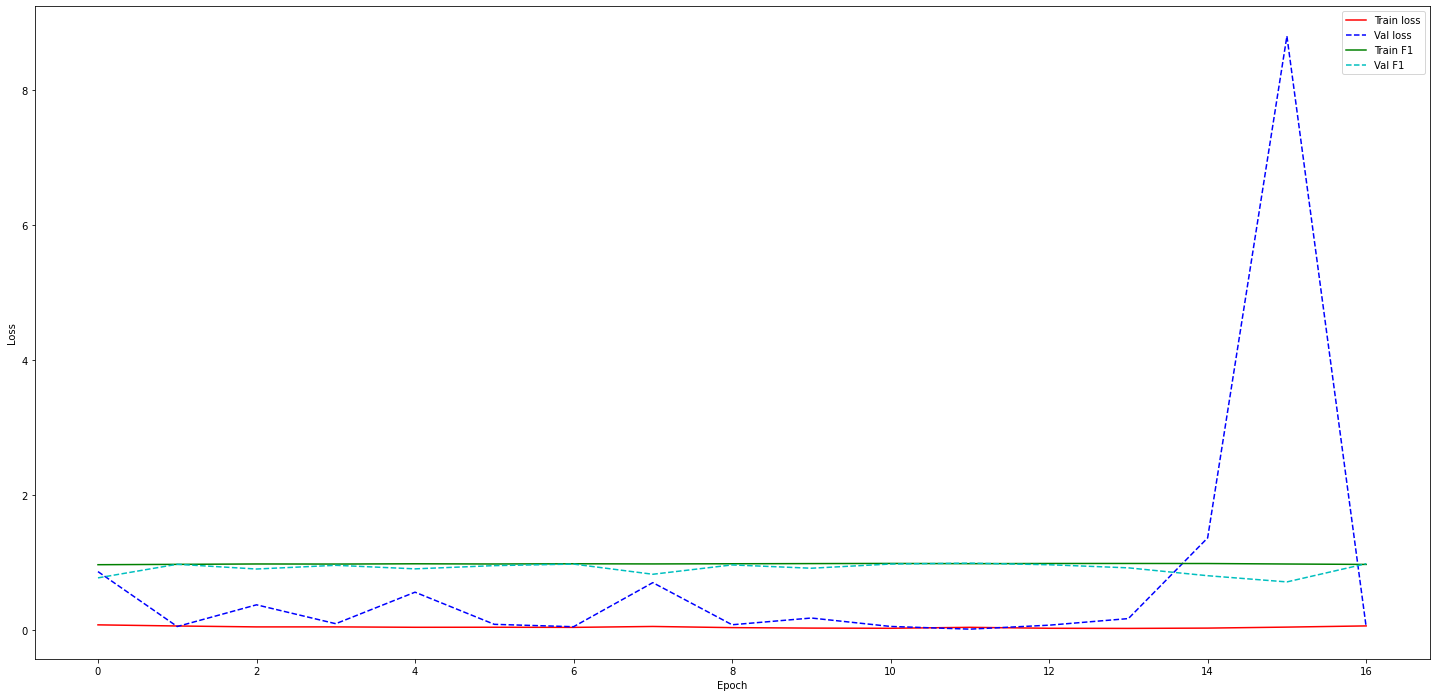

In [ ]:
# Plotting the training and validatoin results
plt.figure(figsize=(25,12))
plt.plot(history_conv1d_ptb.epoch, history_conv1d_ptb.history['loss'],
           color='r', label='Train loss')
plt.plot(history_conv1d_ptb.epoch, history_conv1d_ptb.history['val_loss'],
           color='b', label='Val loss' , linestyle="--")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(history_conv1d_ptb.epoch, history_conv1d_ptb.history['f1_score'],
           color='g', label='Train F1')
plt.plot(history_conv1d_ptb.epoch, history_conv1d_ptb.history['val_f1_score'],
           color='c', label='Val F1' , linestyle="--")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
def build_conv1d_res_model (input_shape=(x_train_ptb.shape[1],1)):
    model = keras.models.Sequential()
    
    input_ = tf.keras.layers.Input (shape=(input_shape))
    
    conv1_1 = Conv1D(64,7, padding='same', input_shape=input_shape) (input_)
    conv1_1 = BatchNormalization() (conv1_1)
    conv1_1 = tf.keras.layers.ReLU() (conv1_1)

    conv1_2 = Conv1D(64,7, padding='same') (conv1_1)
    conv1_2 = BatchNormalization() (conv1_2)
    conv1_2 = tf.keras.layers.ReLU() (conv1_2)
   
    conv1_3 = Conv1D(64,7, padding='same') (conv1_2)
    conv1_3 = BatchNormalization() (conv1_3)
    conv1_3 = tf.keras.layers.ReLU() (conv1_3)

    concat_1 = Concatenate()([conv1_1 , conv1_3 ])
    max_1 = MaxPool1D(5, padding="same") (concat_1)
    
    conv1_4 = Conv1D(128,7, padding='same') (max_1)
    conv1_4 = BatchNormalization() (conv1_4)
    conv1_4 = tf.keras.layers.ReLU() (conv1_4)

    conv1_5 = Conv1D(128,7, padding='same', input_shape=input_shape) (conv1_4)
    conv1_5 = BatchNormalization() (conv1_5)
    conv1_5 = tf.keras.layers.ReLU() (conv1_5)
    
    conv1_6 = Conv1D(128,7, padding='same', input_shape=input_shape) (conv1_5)
    conv1_6 = BatchNormalization() (conv1_6)
    conv1_6 = tf.keras.layers.ReLU() (conv1_6)

    concat_2 = Concatenate()([conv1_4, conv1_6])
    max_2 = MaxPool1D(5, padding="same") (concat_2)

    flat = Flatten() (max_2)
    dense_1 = Dense(512, activation='relu') (flat)
    drop_1 = Dropout(0.5) (dense_1)
    dense_2 = Dense(256, activation='relu') (drop_1)
    drop_2 = Dropout(0.5) (dense_2)
    dense_3 = Dense(128, activation='relu') (drop_2)
    dense_4 = Dense(64, activation='relu') (dense_3)
    dense_5 = Dense(32, activation='relu') (dense_4)
    dense_6 = Dense(2, activation="softmax") (dense_5)
    
    model = Model (inputs=input_ , outputs=dense_6)
    
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=[tfa.metrics.F1Score(2,"micro")])
    return model

In [ ]:
checkpoint_cb = ModelCheckpoint("conv1d_res_ptb.h5", save_best_only=True)

earlystop_cb = EarlyStopping(patience=5, restore_best_weights=True)

inp_shape = (x_train_ptb.shape[1], x_train_ptb.shape[2])
model_conv1d_res_ptb= build_conv1d_res_model(input_shape=(x_train_ptb.shape[1], x_train_ptb.shape[2]))
#model_conv1d_res_ptb.build(inp_shape

In [ ]:
history_conv1d_res_ptb = model_conv1d_res_ptb.fit(x_train_ptb, y_train_ptb, epochs=40, batch_size=32, 
                                          class_weight=class_weight, validation_data=(x_valid_ptb, y_valid_ptb),  
                                          callbacks=[checkpoint_cb, earlystop_cb])

Epoch 1/40
310/310 [==============================] - 8s 15ms/step - loss: 0.4925 - f1_score: 0.7489 - val_loss: 0.5511 - val_f1_score: 0.7401
Epoch 2/40
310/310 [==============================] - 4s 12ms/step - loss: 0.2052 - f1_score: 0.9202 - val_loss: 0.1749 - val_f1_score: 0.9208
Epoch 3/40
310/310 [==============================] - 4s 12ms/step - loss: 0.1283 - f1_score: 0.9534 - val_loss: 0.1163 - val_f1_score: 0.9588
Epoch 4/40
310/310 [==============================] - 4s 11ms/step - loss: 0.0812 - f1_score: 0.9731 - val_loss: 0.2135 - val_f1_score: 0.9091
Epoch 5/40
310/310 [==============================] - 4s 12ms/step - loss: 0.0674 - f1_score: 0.9792 - val_loss: 0.1012 - val_f1_score: 0.9673
Epoch 6/40
310/310 [==============================] - 4s 12ms/step - loss: 0.0739 - f1_score: 0.9753 - val_loss: 0.0404 - val_f1_score: 0.9834
Epoch 7/40
310/310 [==============================] - 4s 11ms/step - loss: 0.0508 - f1_score: 0.9826 - val_loss: 0.0411 - val_f1_score: 0.9891

In [ ]:
model_conv1d_res_ptb.load_weights("conv1d_res_ptb.h5")
model_conv1d_res_ptb.evaluate(x_test_ptb,y_test_ptb)

69/69 [==============================] - 0s 5ms/step - loss: 0.0544 - f1_score: 0.9890


[0.05437076464295387, 0.989005982875824]

In [ ]:
# Calculating the predictions based on the highest probability class
conv1d_res_pred_proba_ptb = model_conv1d_res_ptb.predict (x_test_ptb)
conv1d_res_pred_ptb = np.argmax(conv1d_res_pred_proba_ptb, axis=1)

In [ ]:
print(classification_report(out_test_ptb, conv1d_res_pred_ptb > 0.5, target_names=[PTB_Outcome[i] for i in PTB_Outcome]))

              precision    recall  f1-score   support

      Normal       1.00      0.96      0.98       616
    Abnormal       0.99      1.00      0.99      1567

    accuracy                           0.99      2183
   macro avg       0.99      0.98      0.99      2183
weighted avg       0.99      0.99      0.99      2183



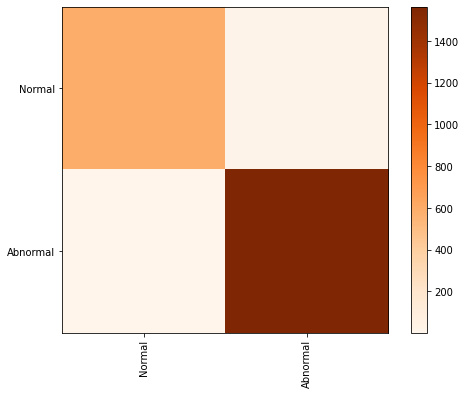

In [ ]:
cm = confusion_matrix(y_true= out_test_ptb, y_pred=conv1d_res_pred_ptb, labels=list(PTB_Outcome.keys()))
plt.figure(figsize=(8,6))
plt.imshow(cm, cmap="Oranges")
plt.colorbar()
plt.xticks(list(PTB_Outcome.keys()),[PTB_Outcome[i] for i in PTB_Outcome], rotation=90)
plt.yticks(list(PTB_Outcome.keys()),[PTB_Outcome[i] for i in PTB_Outcome])
plt.show()

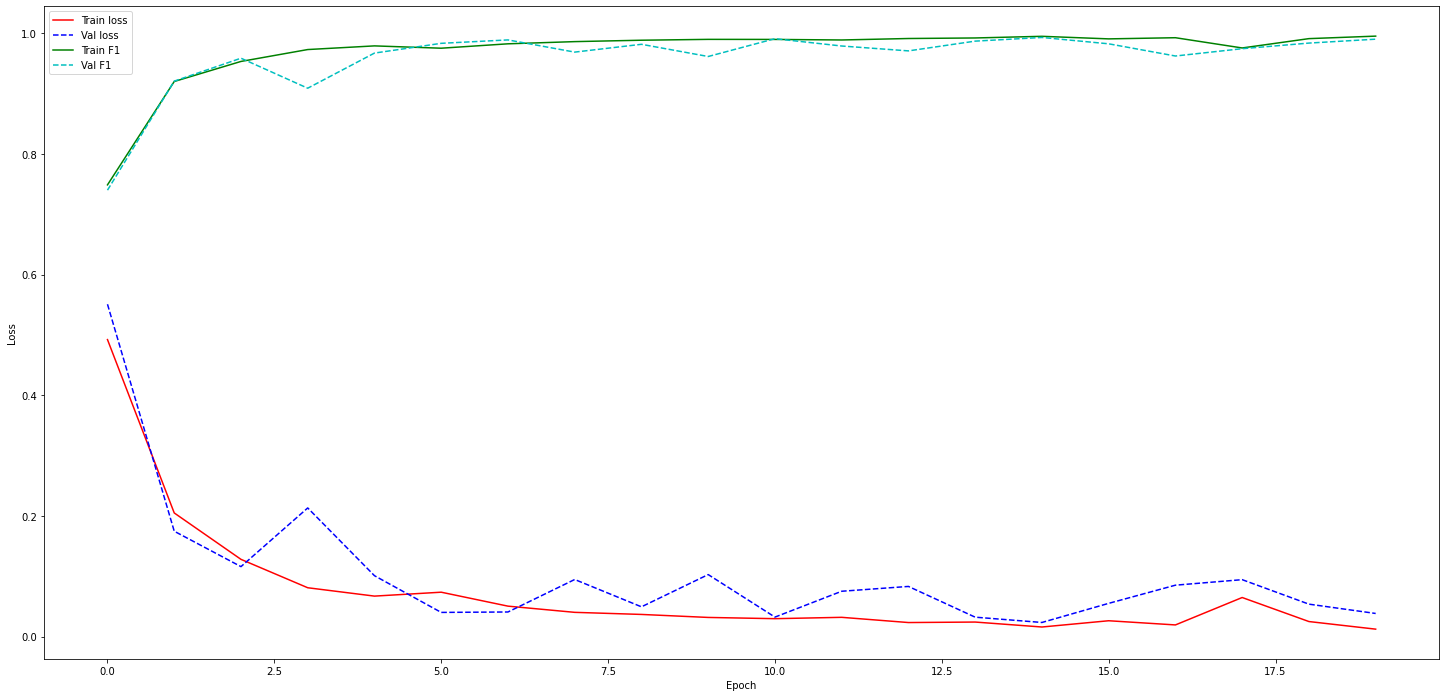

In [ ]:
# Plotting the training and validatoin results
plt.figure(figsize=(25,12))
plt.plot(history_conv1d_res_ptb.epoch, history_conv1d_res_ptb.history['loss'],
           color='r', label='Train loss')
plt.plot(history_conv1d_res_ptb.epoch, history_conv1d_res_ptb.history['val_loss'],
           color='b', label='Val loss' , linestyle="--")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(history_conv1d_res_ptb.epoch, history_conv1d_res_ptb.history['f1_score'],
           color='g', label='Train F1')
plt.plot(history_conv1d_res_ptb.epoch, history_conv1d_res_ptb.history['val_f1_score'],
           color='c', label='Val F1' , linestyle="--")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

**MIT Dataset Analysis**

In [ ]:
# Since the MIT dataset already comes as a train set and test set, we just split 20% of the training set for validation
train_mit, valid_mit, out_train_mit, out_valid_mit = train_test_split(mit_train.iloc[:,:187], mit_train.iloc[:,-1], test_size=0.20, random_state=42)

#we remove the targets from the test set
test_mit, out_test_mit = mit_test.iloc[:,:187], mit_test.iloc[:,-1]

#Normalizing the training & test data 
train_mit = normalize(train_mit, axis=0, norm='max')
valid_mit = normalize(valid_mit, axis=0, norm='max')
test_mit = normalize(test_mit, axis=0, norm='max')

In [ ]:
# Reshaping the dataframe into a 3-D Numpy array (batch, Time Period, Value)
x_train_mit = train_mit.reshape(len(train_mit),train_mit.shape[1],1)
x_valid_mit = valid_mit.reshape(len(valid_mit),valid_mit.shape[1],1)
x_test_mit = test_mit.reshape(len(test_mit),test_mit.shape[1],1)

# Converting the output into a categorical array for each class
y_train_mit = to_categorical(out_train_mit)
y_valid_mit = to_categorical(out_valid_mit)
y_test_mit = to_categorical(out_test_mit)

In [ ]:
print("Traing dataset size: ", x_train_mit.shape , " -- Y size: ", y_train_mit.shape)
print("Validation dataset size: ", x_valid_mit.shape , " -- Y size: ", y_valid_mit.shape)
print("Test dataset size: ", x_test_mit.shape , " -- Y size: ", y_test_mit.shape)

Traing dataset size:  (70043, 187, 1)  -- Y size:  (70043, 5)
Validation dataset size:  (17511, 187, 1)  -- Y size:  (17511, 5)
Test dataset size:  (21892, 187, 1)  -- Y size:  (21892, 5)


In [ ]:
# Calculating the class weights dictionary to feed into the model
normalmit, superpre, prevent, fusion, unclass = np.bincount(mit_train.loc[:,'Class'])
total_rec = len(mit_train)
normmit_weight = (1/normalmit) * (total_rec/5)
superpre_weight = (1/superpre) * (total_rec/5)
prevent_weight = (1/prevent) * (total_rec/5)
fusion_weight =  (1/fusion) * (total_rec/5)
unclass_weight = (1/unclass) * (total_rec/5)
class_weight_mit = {0: normmit_weight, 1: superpre_weight, 2: prevent_weight,
               3: fusion_weight, 4: unclass_weight}

In [ ]:
tf.keras.backend.clear_session()

#Function to build Convolutional 1D Networks
def build_conv1d_model_mit (input_shape=(x_train_mit.shape[1],1)):
    model = keras.models.Sequential()
    
    model.add(Conv1D(32,7, padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    model.add(MaxPool1D(5,padding='same'))

    model.add(Conv1D(64,7, padding='same'))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    model.add(MaxPool1D(5,padding='same'))

    model.add(Conv1D(128,7, padding='same'))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    model.add(MaxPool1D(5,padding='same'))

    model.add(Conv1D(256,7, padding='same'))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    model.add(MaxPool1D(5,padding='same'))
    
    model.add(Conv1D(512,7, padding='same'))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    model.add(MaxPool1D(5,padding='same'))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(5, activation="softmax"))
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=[tfa.metrics.F1Score(5,"micro")])
    return model

In [ ]:
checkpoint_cb = ModelCheckpoint("conv1d_mit.h5", save_best_only=True)

earlystop_cb = EarlyStopping(patience=5, restore_best_weights=True)

model_conv1d_mit= build_conv1d_model_mit(input_shape=(x_train_mit.shape[1], x_train_mit.shape[2]))
model_conv1d_mit.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 187, 32)           256       
                                                                 
 batch_normalization (BatchN  (None, 187, 32)          128       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 187, 32)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 38, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 38, 64)            14400     
                                                                 
 batch_normalization_1 (Batc  (None, 38, 64)           2

In [ ]:
history_conv1d_mit = model_conv1d_mit.fit(x_train_mit, y_train_mit, epochs=40, batch_size=32, 
                             class_weight=class_weight_mit, validation_data=(x_valid_mit, y_valid_mit),  
                             callbacks=[checkpoint_cb, earlystop_cb])

Epoch 1/40
2189/2189 [==============================] - 26s 11ms/step - loss: 0.8396 - f1_score: 0.6000 - val_loss: 0.7905 - val_f1_score: 0.6725
Epoch 2/40
2189/2189 [==============================] - 22s 10ms/step - loss: 0.6057 - f1_score: 0.7419 - val_loss: 0.7696 - val_f1_score: 0.7827
Epoch 3/40
2189/2189 [==============================] - 23s 10ms/step - loss: 0.5185 - f1_score: 0.8157 - val_loss: 0.4511 - val_f1_score: 0.8900
Epoch 4/40
2189/2189 [==============================] - 23s 10ms/step - loss: 0.4974 - f1_score: 0.7999 - val_loss: 2.3977 - val_f1_score: 0.3673
Epoch 5/40
2189/2189 [==============================] - 23s 11ms/step - loss: 0.5083 - f1_score: 0.8273 - val_loss: 0.7586 - val_f1_score: 0.7399
Epoch 6/40
2189/2189 [==============================] - 23s 11ms/step - loss: 0.4326 - f1_score: 0.8529 - val_loss: 0.5604 - val_f1_score: 0.8279
Epoch 7/40
2189/2189 [==============================] - 23s 10ms/step - loss: 0.3744 - f1_score: 0.8733 - val_loss: 0.7917 -

In [ ]:
model_conv1d_mit.load_weights("conv1d_mit.h5")
model_conv1d_mit.evaluate(x_test_mit, y_test_mit)
conv1d_pred_mit_proba = model_conv1d_mit.predict (x_test_mit)
conv1d_pred_mit = np.argmax(conv1d_pred_mit_proba,axis=1)

685/685 [==============================] - 5s 7ms/step - loss: 0.2579 - f1_score: 0.9190


In [ ]:
print(classification_report(out_test_mit, conv1d_pred_mit, target_names=[MIT_Outcome[i] for i in MIT_Outcome]))

                                       precision    recall  f1-score   support

                          Normal Beat       0.99      0.92      0.95     18118
      Supraventricular premature beat       0.47      0.77      0.58       556
    Premature ventricular contraction       0.80      0.91      0.85      1448
Fusion of ventricular and normal beat       0.17      0.93      0.29       162
                  Unclassifiable beat       0.98      0.96      0.97      1608

                             accuracy                           0.92     21892
                            macro avg       0.68      0.90      0.73     21892
                         weighted avg       0.96      0.92      0.93     21892



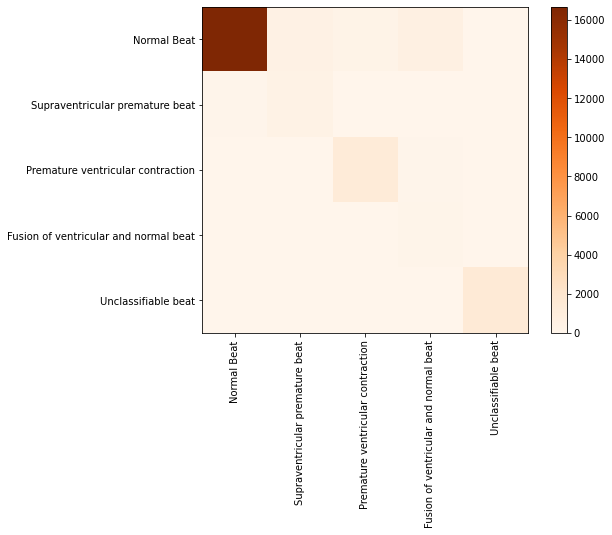

In [ ]:
cm = confusion_matrix(y_true= out_test_mit, y_pred=conv1d_pred_mit, labels=list(MIT_Outcome.keys()))
plt.figure(figsize=(8,6))
plt.imshow(cm, cmap="Oranges")
plt.colorbar()
plt.xticks(list(MIT_Outcome.keys()),[MIT_Outcome[i] for i in MIT_Outcome], rotation=90)
plt.yticks(list(MIT_Outcome.keys()),[MIT_Outcome[i] for i in MIT_Outcome])
plt.show()

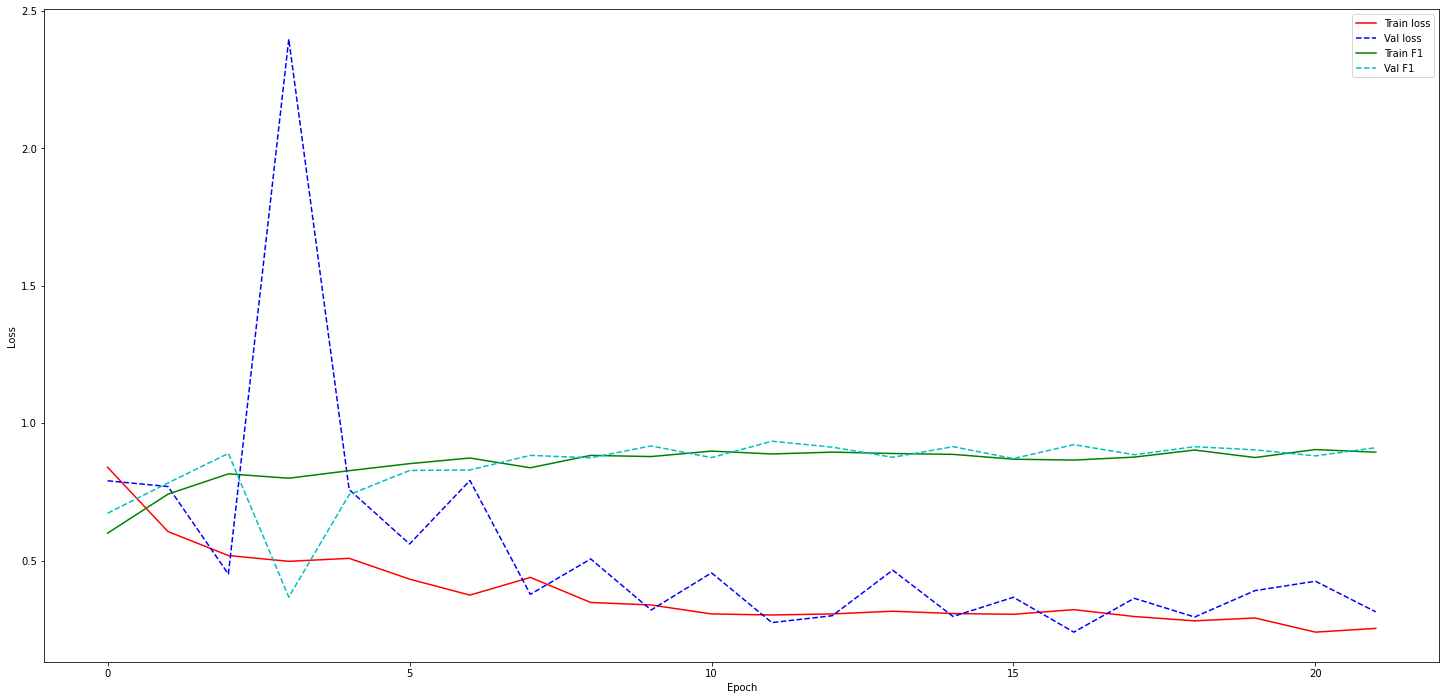

In [ ]:
# Plotting the training and validatoin results
plt.figure(figsize=(25,12))
plt.plot(history_conv1d_mit.epoch, history_conv1d_mit.history['loss'],
           color='r', label='Train loss')
plt.plot(history_conv1d_mit.epoch, history_conv1d_mit.history['val_loss'],
           color='b', label='Val loss' , linestyle="--")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(history_conv1d_mit.epoch, history_conv1d_mit.history['f1_score'],
           color='g', label='Train F1')
plt.plot(history_conv1d_mit.epoch, history_conv1d_mit.history['val_f1_score'],
           color='c', label='Val F1' , linestyle="--")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
def build_conv1d_res_model_mit (input_shape=(x_train_mit.shape[1],1)):
    model = keras.models.Sequential()
    
    input_ = tf.keras.layers.Input (shape=(input_shape))
        
    conv1_1 = Conv1D(64,7, padding='same', input_shape=input_shape) (input_)
    conv1_1 = BatchNormalization() (conv1_1)
    conv1_1 = tf.keras.layers.ReLU() (conv1_1)

    conv1_2 = Conv1D(64,7, padding='same') (conv1_1)
    conv1_2 = BatchNormalization() (conv1_2)
    conv1_2 = tf.keras.layers.ReLU() (conv1_2)
    
    conv1_3 = Conv1D(64,7, padding='same') (conv1_2)
    conv1_3 = BatchNormalization() (conv1_3)
    conv1_3 = tf.keras.layers.ReLU() (conv1_3)

    concat_1 = Concatenate()([conv1_1 , conv1_3 ])
    max_1 = MaxPool1D(5, padding="same") (concat_1)
    
    conv1_4 = Conv1D(128,7, padding='same') (max_1)
    conv1_4 = BatchNormalization() (conv1_4)
    conv1_4 = tf.keras.layers.ReLU() (conv1_4)

    conv1_5 = Conv1D(128,7, padding='same', input_shape=input_shape) (conv1_4)
    conv1_5 = BatchNormalization() (conv1_5)
    conv1_5 = tf.keras.layers.ReLU() (conv1_5)
    
    conv1_6 = Conv1D(128,7, padding='same', input_shape=input_shape) (conv1_5)
    conv1_6 = BatchNormalization() (conv1_6)
    conv1_6 = tf.keras.layers.ReLU() (conv1_6)

    concat_2 = Concatenate()([conv1_4, conv1_6])
    max_2 = MaxPool1D(5, padding="same") (concat_2)
    
    conv1_7 = Conv1D(256,7, padding='same') (max_2)
    conv1_7 = BatchNormalization() (conv1_7)
    conv1_7 = tf.keras.layers.ReLU() (conv1_7)

    conv1_8 = Conv1D(256,7, padding='same') (conv1_7)
    conv1_8 = BatchNormalization() (conv1_8)
    conv1_8 = tf.keras.layers.ReLU() (conv1_8)

    conv1_9 = Conv1D(256,7, padding='same') (conv1_8)
    conv1_9 = BatchNormalization() (conv1_9)
    conv1_9 = tf.keras.layers.ReLU() (conv1_9)

    concat_3 = Concatenate()([conv1_7, conv1_9])
    max_3 = MaxPool1D(5, padding="same") (concat_3)

    flat = Flatten() (max_3)
    dense_1 = Dense(512, activation='relu') (flat)
    drop_1 = Dropout(0.5) (dense_1)
    dense_2 = Dense(256, activation='relu') (drop_1)
    drop_2 = Dropout(0.5) (dense_2)
    dense_3 = Dense(128, activation='relu') (drop_2)
    dense_4 = Dense(64, activation='relu') (dense_3)
    dense_5 = Dense(32, activation='relu') (dense_4)
    dense_6 = Dense(5, activation="softmax") (dense_5)
        
    model = Model (inputs=input_ , outputs=dense_6)
    
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=[tfa.metrics.F1Score(2,"micro")])
    return model